In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import timm
from timm.loss import LabelSmoothingCrossEntropy

In [4]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import sys
from tqdm import tqdm
import time
import copy

In [8]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [9]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [10]:
!unzip "/content/drive/MyDrive/vision_transformer.zip" -d "/content/"

Archive:  /content/drive/MyDrive/vision_transformer.zip
   creating: /content/vision_transformer/test/
   creating: /content/vision_transformer/test/Pothole/
  inflating: /content/vision_transformer/test/Pothole/pothole401.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole402.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole403.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole404.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole405.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole406.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole407.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole408.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole409.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole410.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole411.jpg  
  inflating: /content/vision_transformer/test/Pothole/pothole

In [11]:
dataset_path = "/content/vision_transformer"

In [12]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [13]:
classes = get_classes("/content/vision_transformer/train")
print(classes, len(classes))

['Pothole', 'speedbreaker'] 2


In [14]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [15]:
print(len(train_loader), len(val_loader), len(test_loader))

25 10 4


In [16]:
print(train_data_len, valid_data_len, test_data_len)

800 313 100


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 35.7MB/s]


In [19]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
)


In [20]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [21]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
'''def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    print("Best Val Acc: {:.4f}".format(best_acc))
    save_path = 'vision_trained_model.pth'
    torch.save(best_model_wts, save_path)

    model.load_state_dict(best_model_wts)
    return model'''

In [23]:
def get_true_pred_labels(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred


In [27]:
# @title
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

def train_model_with_kfold(model, criterion, optimizer, scheduler, k_folds=5, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)  # Define the k-fold cross-validator

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for fold, (train_index, val_index) in enumerate(skf.split(train_data_len)):  # X and y represent your dataset and labels
        print(f'Fold {fold + 1}/{k_folds}')
        print("-" * 10)

        # Split the data into train and validation sets for this fold
        train_loader, val_loader = get_data_loaders(train_index, val_index)  # Implement a function to get data loaders for indices

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print("-" * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            print()

        # Calculate metrics for this fold
        y_true, y_pred = get_true_pred_labels(model, val_loader, device)  # Implement a function to get true and predicted labels
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Store metrics in lists
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print("Fold {} Metrics - Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}".format(fold + 1, accuracy, precision, recall, f1))
        print("-" * 10)

    print("Best Val Acc: {:.4f}".format(best_acc))

    # Return the lists of metrics for all folds
    return accuracy_list, precision_list, recall_list, f1_list


In [ ]:
# @title
model_ft = train_model_with_kfold(model, criterion, optimizer, exp_lr_scheduler)

In [ ]:
# @title
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim

'''def create_model():
    HUB_URL = "SharanSMenon/swin-transformer-hub:main"
    MODEL_NAME = "swin_tiny_patch4_window7_224"
    model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    n_inputs = model.head.in_features
    custom_head = nn.Sequential(
        nn.Linear(n_inputs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, len(classes))
    )
    model.head = custom_head
    model = model.to(device)
    return model'''

num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_models = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
accuracies=[]

batch_size = 32
dataset_path = "/content/vision_transformer"
(train_loader, train_data_len) = get_data_loaders(dataset_path, batch_size, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, batch_size, train=False)

#model = create_model()

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

for fold, (train_indices, val_indices) in enumerate(kf.split(range(train_data_len))):
    print(f'Fold {fold + 1}/{num_folds}')
    print("-" * 10)

    train_data = Subset(train_loader.dataset, train_indices)
    val_data = Subset(train_loader.dataset, val_indices)

    train_loader_fold = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader_fold = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    best_acc = 0.0

    for epoch in range(50):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader_fold):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader_fold.dataset)

        model.eval()
        running_corrects = 0.0
        for inputs, labels in tqdm(val_loader_fold):
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / len(val_loader_fold.dataset)

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    precision = precision_score(labels.cpu(), preds.cpu(), average='weighted')
    recall = recall_score(labels.cpu(), preds.cpu(), average='weighted')
    f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
    accuracy = accuracy_score(labels.cpu(), preds.cpu())


    accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

average_precision = np.mean(fold_precisions)
average_accuracy= np.mean(accuracies)
average_recall = np.mean(fold_recalls)
average_f1_score = np.mean(fold_f1_scores)
best_fold_index = np.argmax(fold_f1_scores)

print("Average Precision: {:.4f}".format(average_precision))
print("Average Recall: {:.4f}".format(average_recall))
print("Average F1 Score: {:.4f}".format(average_f1_score))
print("Average Accuracy Score : {:.4f}".format(average_accuracy))
#print("Best Fold (based on F1 score): {}".format(best_fold_index + 1))


Fold 1/5
----------


100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Fold 2/5
----------


100%|██████████| 5/5 [00:00<00:00,  6.04it/s]


Fold 3/5
----------


100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


Fold 4/5
----------


100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Fold 5/5
----------


100%|██████████| 5/5 [00:00<00:00,  5.80it/s]

Average Precision: 1.0000
Average Recall: 0.9875
Average F1 Score: 0.9937
Average Accuracy Score : 0.9875


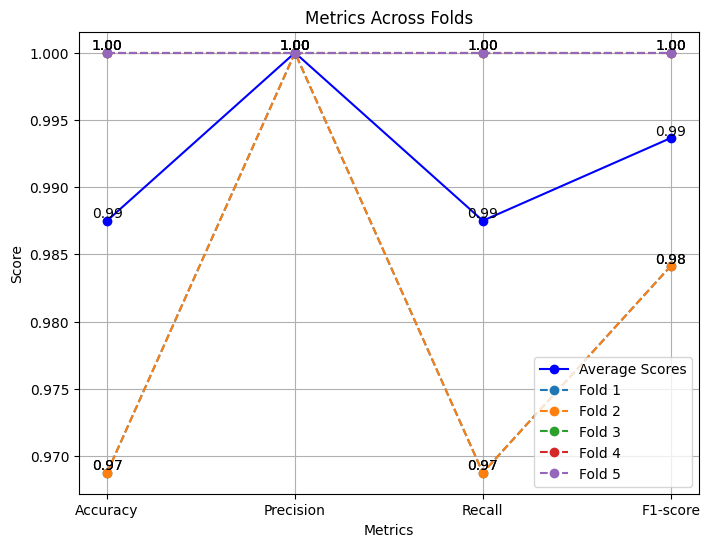

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))


num_folds = 5


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
average_scores = [average_accuracy, average_precision, average_recall, average_f1_score]


plt.plot(metrics, average_scores, marker='o', color='b', label='Average Scores')
for i, metric_value in enumerate(average_scores):
    plt.text(metrics[i], metric_value, f'{metric_value:.2f}', ha='center', va='bottom')


for fold_idx in range(num_folds):
    fold_scores = [accuracies[fold_idx], fold_precisions[fold_idx], fold_recalls[fold_idx], fold_f1_scores[fold_idx]]
    plt.plot(metrics, fold_scores, marker='o', linestyle='--', label=f'Fold {fold_idx + 1}')
    for i, metric_value in enumerate(fold_scores):
        plt.text(metrics[i], metric_value, f'{metric_value:.2f}', ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Metrics Across Folds')
plt.legend()
plt.grid(True)
plt.show()